---
title: Bloch-Redfield and Redfield Failing for degenerate Hamiltonians
date: 2024-08-08
authors:
  - name: Gerardo Suarez
---

### In The SYK model:

In this section we consider the SYK model whose Hamiltonian is given by ([Ryu paper](https://arxiv.org/pdf/2112.13489), [introduction](https://arxiv.org/pdf/2002.12187))

$$H= \sum_{i<j<k<l=1}^{N} J_{i,j,k,l}\psi_{i} \psi_{j} \psi_{k} \psi_{l} $$

Where $J_{i,j,k,l}$ is drawn randomly from a Gaussian ensemble with mean $\mu=0$ and variance $\sigma=\sqrt{3!} \frac{J}{N^{3/2}}$
where J is a constant with dimension of mass. And the $\psi_{i}$ denote the operators of the majorana fermions which are representations
of the clifford algebra. They satisfy

\begin{equation}\label{eq:anti}
\{\psi_{i},\psi_{j}\} = \delta_{i,j}
\end{equation}

For convenience people usually just consider the even case and one dimensional majorana fermions ([appendix A](https://arxiv.org/pdf/2002.12187)). 
We introduce the new basis


$$c_{i}= \frac{1}{\sqrt{2}} (\psi_{2i}-i \psi_{2i+1})$$

$$c_{i}^{\dagger}= \frac{1}{\sqrt{2}} (\psi_{2i}+i \psi_{2i+1})$$

These satisfy

$$\{C_{i},C^{\dagger}_{j}\} = \delta_{i,j}$$
$$\{C_{i}^{\dagger},C_{j}^{\dagger}\} = 0$$

To construct this basis we consider picking a vacuum annhilated by all modes such that 

$$(C_{1}^{\dagger})^{n_{1}} \dots (C_{k}^{\dagger})^{n_{k}} \ket{0 \dots 0} = 0$$

There are $2^{N/2}= 2^{K}$ such states. This is the only irreducible representation of @eq:anti , upn top unitary equailvalence, the representation is given by $2^{k}$ matriceswhich can be found by the recursion relaton

\begin{align}
\psi_{i}^{K} = \psi_{i}^{k-1} \otimes \begin{pmatrix}-1 & 0 \\ 0 &1 \end{pmatrix} \quad \text{for} \quad i=1,2,\dots,N-2 \\
\psi_{N-1}^{K} = \frac{1}{\sqrt{2}} 1_{2^{K-1}} \otimes \begin{pmatrix}0 & 1 \\ 1 &0 \end{pmatrix} \\
\psi_{N}^{K} = \frac{1}{\sqrt{2}} 1_{2^{K-1}} \otimes \begin{pmatrix}0 & -i \\ i &0 \end{pmatrix} 
\end{align}

The superscript $K$ is omitted in the Hamiltonian for convenience. Though not a great example, Let us use $N=2$. To illustrate how solving by Bloch-Redfield may fail

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from qutip import ( basis, expect, mesolve, qeye, sigmax, sigmay, sigmaz,destroy,
                   tensor,fidelity,tracedist,brmesolve,Qobj)
from qutip.solver import heom
from scipy.integrate import quad
from pseudomode import pseudomode,zero_temp_bath,rotation
from hamiltonians import syk_full,plot_ground,plot_fidelities,plot_trd,plot_positivity,plot_populations
from nmm import csolve,redfield

In [2]:
N=2
seeds=list(range(42,52))
k=7
H,psis=syk_full(N,seed=seeds[k])

The Hamiltonian in this example is then given  by

In [3]:
H=20*H
H

Quantum object: dims=[[2, 2], [2, 2]], shape=(4, 4), type='oper', isherm=True
Qobj data =
[[-2.18176916  0.          0.          0.        ]
 [ 0.          2.18176916  0.          0.        ]
 [ 0.          0.          2.18176916  0.        ]
 [ 0.          0.          0.         -2.18176916]]

While the coupling operator to the bath is simply 

$Q= \sum_{i} a_{i} \psi_{i}$

Where each $a_{i}$ is a real number

In [4]:
Q=sum([(1/2 +1/(2*i+2))*psis[i] for i in range(len(psis))])
Q

Quantum object: dims=[[2, 2], [2, 2]], shape=(4, 4), type='oper', isherm=True
Qobj data =
[[ 0.        +0.j          0.53033009-0.70710678j  0.44194174-0.47140452j
   0.        +0.j        ]
 [ 0.53033009+0.70710678j  0.        +0.j          0.        +0.j
  -0.44194174+0.47140452j]
 [ 0.44194174+0.47140452j  0.        +0.j          0.        +0.j
   0.53033009-0.70710678j]
 [ 0.        +0.j         -0.44194174-0.47140452j  0.53033009+0.70710678j
   0.        +0.j        ]]

We consider the initial state to be 

In [5]:
N=2
state_list = [basis(2, 1)] + [-1j*basis(2, 0)] * (N - 1) # change the initial state to be away from the ground state
state_list2 = [basis(2, 1)] + [basis(2, 0)] * (N - 1) # change the initial state to be away from the ground state
state_list.reverse()
psi0 = (tensor(state_list)+tensor(state_list2))/np.sqrt(2)
rho0=psi0*psi0.dag()
H.dims=rho0.dims
Q.dims=rho0.dims
times=np.linspace(0,50,100)
tfit=np.linspace(0, 80, 1000)
rho0

Quantum object: dims=[[2, 2], [2, 2]], shape=(4, 4), type='oper', isherm=True
Qobj data =
[[0. +0.j  0. +0.j  0. +0.j  0. +0.j ]
 [0. +0.j  0.5+0.j  0. -0.5j 0. +0.j ]
 [0. +0.j  0. +0.5j 0.5+0.j  0. +0.j ]
 [0. +0.j  0. +0.j  0. +0.j  0. +0.j ]]

In [6]:
E01=H.eigenenergies()[2]-H.eigenenergies()[0]#it is mostly degenerate, this does not help much
w0=1.1 *E01#since I have no g parameter then It doesn't scale uniformingly as ising
gamma=w0/2.05
Gamma=gamma/2
Omega=np.sqrt(w0**2 -Gamma**2)
lam=np.sqrt(Omega)

And consider an underdamped spectral density at zero temperature with $\gamma=${eval}`gamma` , $\lambda=${eval}`lam` ,$\omega_{0}=${eval}`w0`. After fitting the correlation function one obtains

In [7]:
bath = heom.UnderDampedBath(
        Q=Q,
        lam=lam, gamma=gamma, w0=w0, T=0, Nk=5) # fix runtime warning
cfiitter2 = heom.CorrelationFitter(
    Q, 0, tfit, bath.correlation_function)
bath1, fit2info = cfiitter2.get_fit(Ni=1, Nr=2)
# notice one mode is also a pretty good approximation
print(fit2info['summary'])

/home/mcditoos/github/qutip_gsoc_app/qutip/solver/heom/bofin_baths.py:925: RuntimeWarning: invalid value encountered in scalar divide
  * (1 / np.tanh(beta * (Om + 1.0j * Gamma) / 2)),
/home/mcditoos/github/qutip_gsoc_app/qutip/solver/heom/bofin_baths.py:927: RuntimeWarning: invalid value encountered in scalar divide
  * (1 / np.tanh(beta * (Om - 1.0j * Gamma) / 2)),


Fit correlation class instance: 
 
Result of fitting The Real Part Of                                      |Result of fitting The Imaginary Part                                    
 the Correlation Function with 2 terms:                                 | Of the Correlation Function with 1 terms:                              
                                                                        |                                                                        
 Parameters|    a     |    b     |    c                                 | Parameters|    a     |    b     |    c                                 
 1         |-9.49e-02 |-4.50e+00 |5.87e-10                              | 1         |-5.00e-01 |-1.17e+00 |4.65e+00                              
 2         | 5.18e-01 |-1.20e+00 |4.64e+00                              |                                                                        
                                                                        |A  normalized RM

In [8]:
times2 = np.linspace(0,40,500)
cvis = bath.correlation_function(times2)

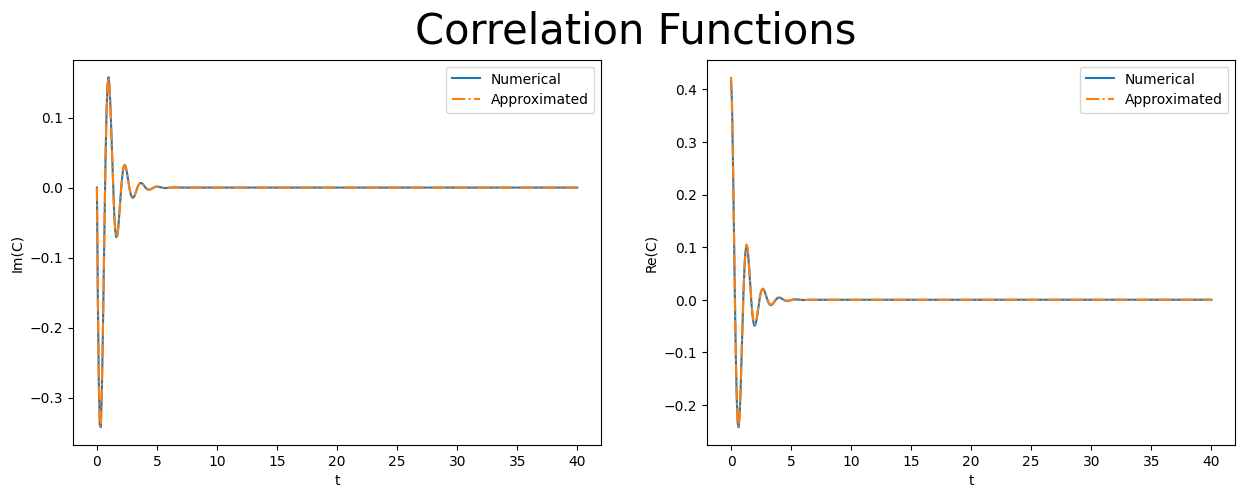

In [9]:
# using the variable axs for multiple Axes
fig, axs = plt.subplots(1, 2,figsize=(15,5))
axs[0].plot(times2, np.imag(cvis),label="Numerical")
axs[0].plot(times2, np.imag(bath1.correlation_function_approx(times2)), "-.",label="Approximated")
axs[0].set_xlabel("t")
axs[0].set_ylabel("Im(C)")
axs[0].legend()
axs[1].plot(times2, np.real(cvis),label="Numerical")
axs[1].plot(times2, np.real(bath1.correlation_function_approx(times2)), "-.",label="Approximated")
axs[1].set_xlabel("t")
axs[1].set_ylabel("Re(C)")
axs[1].legend()
fig.suptitle('Correlation Functions', fontsize=30)
plt.show()

In [11]:
solver = heom.HEOMSolver(H,
                          [bath1], max_depth=7, options={"atol": 1e-14})
result = solver.run(rho0, times)

10.1%. Run time:   5.28s. Est. time left: 00:00:00:47
20.2%. Run time:  10.85s. Est. time left: 00:00:00:42
30.3%. Run time:  16.43s. Est. time left: 00:00:00:37
40.4%. Run time:  22.26s. Est. time left: 00:00:00:32
50.5%. Run time:  28.01s. Est. time left: 00:00:00:27
60.6%. Run time:  33.91s. Est. time left: 00:00:00:22
70.7%. Run time:  39.75s. Est. time left: 00:00:00:16
80.8%. Run time:  46.22s. Est. time left: 00:00:00:10
90.9%. Run time:  56.15s. Est. time left: 00:00:00:05
100.0%. Run time:  63.75s. Est. time left: 00:00:00:00
Total run time:  63.75s


In [13]:
bath.bose=None
cum = csolve(
    Hsys=H, t=times, baths=[bath],
    Qs=[Q],
    eps=1e-6, cython=False)

result_cum = cum.evolution(rho0)

result_cum = rotation(result_cum, H, times)

bath.bose=None

Computing Exponential of Generators . . . .: 100%|█████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 426.55it/s]


In [15]:
red=redfield.redfield(Hsys=H, t=times, baths=[bath],
    Qs=[Q],
    eps=1e-12,matsubara=False)

In [16]:
result_red = red.evolution(rho0)


Started interpolation


In [17]:
result_red = [Qobj(i) for i in result_red]
for i in result_red:
    i.dims=H.dims

In [18]:
result_red = rotation(result_red, H, times)

In [19]:
a_ops = [[Q, bath.power_spectrum]]
resultBR = brmesolve(H, rho0, times, a_ops=a_ops, options={
    "rtol": 1e-14}, sec_cutoff=-1)

a_ops = [[Q, bath.power_spectrum]]
resultBR2 = brmesolve(H, rho0, times, a_ops=a_ops, options={
    "rtol": 1e-14},sec_cutoff=.00000000001)

In [20]:
global_one=cum.jump_operators(Q) # Global Jump Operators for Bath 1 2->4


In [21]:
c_ops2=[Qobj((np.sqrt(bath.power_spectrum(k))*v).data) for k, v in global_one.items()]
for i in range(len(c_ops2)):
    c_ops2[i].dims=H.dims 
result_lindblad_global2 = mesolve(H, rho0, times, c_ops2)

In [23]:
Ncutoff=3
modes=2
bathu = zero_temp_bath(Q, tfit, lam, gamma, w0, N=modes)
example = pseudomode(Hsys=H, Q=Q, bath=bathu)

In [24]:
ans = example.evolution(rho0, Ncutoff, times, options={
                        "atol": 1e-14, "normalize_output": False, "store_states": True})
ans = [i.ptrace(range(N))for i in ans.states]

In [33]:
results=[result,result_cum,resultBR,result_lindblad_global2,result_red,ans]

In [36]:
def plot_fidelities(states,H,times):
    labels=["HEOM","Cumulant","Bloch-redfield","Global","Redfield","Pseudomodes"]
    style=["solid","solid","dashed","dashdot",'dashed',"solid"]
    for k,i in enumerate(states[1:],1):
        try:
            sdd=np.array([fidelity(i.states[j],states[0].states[j]) for j in range(len(times))])
        except:
            sdd=np.array([fidelity(i[j],states[0].states[j]) for j in range(len(times))])
        plt.plot(times,sdd,label=labels[k],linestyle=style[k])
    plt.legend(fontsize=14)
    plt.ylabel(r"$\mathcal{F}_{HEOM}$",fontsize=20)
    plt.xlabel(r"t",fontsize=20)
    plt.show()


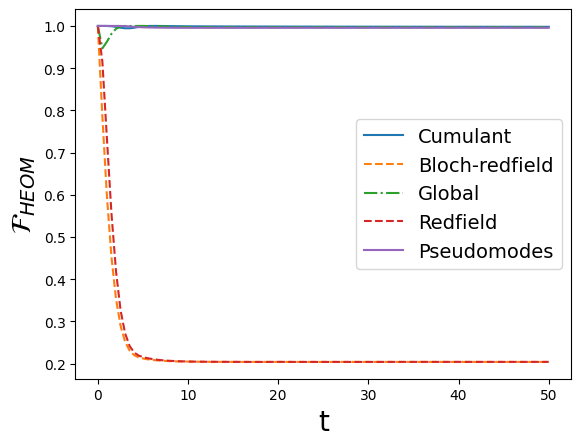

In [37]:
plot_fidelities(results,H,times)

In [39]:
def trd(states,H,times):
    labels=["HEOM","Cumulant","Bloch-redfield","Global","Redfield","Pseudomodes"]
    style=["solid","solid","dashed","dashdot",'dashed',"solid"]
    for k,i in enumerate(states[1:],1):
        try:
            sdd=np.array([tracedist(i.states[j],states[0].states[j]) for j in range(len(times))])
        except:
            sdd=np.array([tracedist(i[j],states[0].states[j]) for j in range(len(times))])
        plt.plot(times,sdd,label=labels[k],linestyle=style[k])
    plt.legend(fontsize=14)
    plt.ylabel(r"$1-TR_{HEOM}$",fontsize=20)
    plt.xlabel(r"t",fontsize=20)
    plt.show()

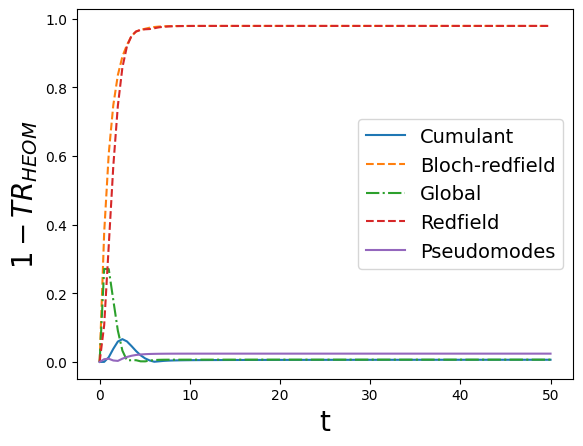

In [40]:
trd(results,H,times)

From what we see in both the trace distance and fidelity plots, the Bloch-Redfield approach does terribly when we consider this scenario (multiple implementations where checked). Notice that this issue seems to be about the coupling operator, rather than the Hamiltonian. Consider a different coupling operator (The real part of the previous one)

In [48]:
Q2=Qobj(np.real(Q.full()))
Q2

Quantum object: dims=[[4], [4]], shape=(4, 4), type='oper', isherm=True
Qobj data =
[[ 0.          0.53033009  0.44194174  0.        ]
 [ 0.53033009  0.          0.         -0.44194174]
 [ 0.44194174  0.          0.          0.53033009]
 [ 0.         -0.44194174  0.53033009  0.        ]]

In [49]:
bath = heom.UnderDampedBath(
        Q=Q2,
        lam=lam, gamma=gamma, w0=w0, T=0, Nk=5) # fix runtime warning
cfiitter2 = heom.CorrelationFitter(
    Q, 0, tfit, bath.correlation_function)
bath1, fit2info = cfiitter2.get_fit(Ni=1, Nr=2)
# notice one mode is also a pretty good approximation
print(fit2info['summary'])

Fit correlation class instance: 
 
Result of fitting The Real Part Of                                      |Result of fitting The Imaginary Part                                    
 the Correlation Function with 2 terms:                                 | Of the Correlation Function with 1 terms:                              
                                                                        |                                                                        
 Parameters|    a     |    b     |    c                                 | Parameters|    a     |    b     |    c                                 
 1         |-9.49e-02 |-4.50e+00 |5.87e-10                              | 1         |-5.00e-01 |-1.17e+00 |4.65e+00                              
 2         | 5.18e-01 |-1.20e+00 |4.64e+00                              |                                                                        
                                                                        |A  normalized RM

In [50]:
solver = heom.HEOMSolver(H,
                          [bath1], max_depth=7, options={"atol": 1e-14})
result = solver.run(rho0, times)

10.1%. Run time:   7.31s. Est. time left: 00:00:01:05
20.2%. Run time:  15.80s. Est. time left: 00:00:01:02
30.3%. Run time:  22.91s. Est. time left: 00:00:00:52
40.4%. Run time:  32.29s. Est. time left: 00:00:00:47
50.5%. Run time:  40.47s. Est. time left: 00:00:00:39
60.6%. Run time:  51.00s. Est. time left: 00:00:00:33
70.7%. Run time:  61.15s. Est. time left: 00:00:00:25
80.8%. Run time:  70.82s. Est. time left: 00:00:00:16
90.9%. Run time:  80.06s. Est. time left: 00:00:00:08
100.0%. Run time:  87.82s. Est. time left: 00:00:00:00
Total run time:  87.82s


In [51]:
bath.bose=None
cum = csolve(
    Hsys=H, t=times, baths=[bath],
    Qs=[Q],
    eps=1e-6, cython=False)

result_cum = cum.evolution(rho0)

result_cum = rotation(result_cum, H, times)

bath.bose=None

Computing Exponential of Generators . . . .: 100%|█████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 546.26it/s]


In [52]:
red=redfield.redfield(Hsys=H, t=times, baths=[bath],
    Qs=[Q],
    eps=1e-12,matsubara=False)

In [53]:
result_red = red.evolution(rho0)
result_red = [Qobj(i) for i in result_red]
for i in result_red:
    i.dims=H.dims
result_red = rotation(result_red, H, times)

Started interpolation


In [54]:
a_ops = [[Q, bath.power_spectrum]]
resultBR = brmesolve(H, rho0, times, a_ops=a_ops, options={
    "rtol": 1e-14}, sec_cutoff=-1)

a_ops = [[Q, bath.power_spectrum]]
resultBR2 = brmesolve(H, rho0, times, a_ops=a_ops, options={
    "rtol": 1e-14})

In [55]:
global_one=cum.jump_operators(Q) # Global Jump Operators for Bath 1 2->4
c_ops2=[Qobj((np.sqrt(bath.power_spectrum(k))*v).data) for k, v in global_one.items()]
for i in range(len(c_ops2)):
    c_ops2[i].dims=H.dims 
result_lindblad_global2 = mesolve(H, rho0, times, c_ops2)

In [56]:
Ncutoff=3
modes=2
bathu = zero_temp_bath(Q2, tfit, lam, gamma, w0, N=modes)
example = pseudomode(Hsys=H, Q=Q2, bath=bathu)

In [61]:
Q2.dims=Q.dims

In [ ]:
ans = example.evolution(rho0, Ncutoff, times, options={
                        "atol": 1e-14, "normalize_output": False, "store_states": True})
ans = [i.ptrace(range(N))for i in ans.states]

In [ ]:
results=[result,result_cum,resultBR,result_lindblad_global2,result_red,ans]

In [28]:
from qutip import qsave,qload

In [ ]:
#qsave(results,f"N={N}_syk_{lam}_nocheating_seed_{seeds[k]}")